# ditto-counter
Segmentation and counting Ditto's on image. (Homework for course Soft Computing) 

Goal of this script is to segment and count Ditto Pokemons on image. Algorithms that will be used cover basic **image preprocessing** (conversion to HSV and binary format, applying mask to extract purple segments on image) and **watershed algorithm** for segments counting.

All code for image preprocessing can be found in script 'preprocessing.py'.

In [204]:
%load 'preprocessing.py'

At the beginning, all images are loaded and for purposes of this script, one of the images is selected as an example.

> To run a full script where all images are processed and mean average error is calculated, please run script 'main.py' with the following command:  
> ```shell
> python3 main.py pictures/
> ```
> Output of each picture will be in form '*picture_name*-*actual_value*-*predicted_value*'. Mean avereage error will be shown in the last line of output.


In [ ]:
path = "pictures/"
image_paths = read_all_images(path)
image_paths

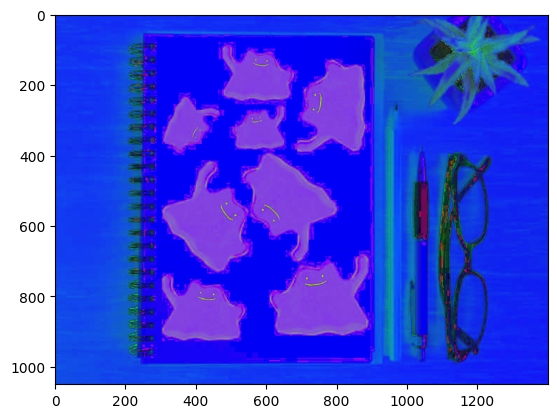

In [206]:
selected_path_index = 1
path = image_paths[selected_path_index]
image = load_image_hsv(path)
display_image(image)

Image is right away loaded in **HSV** format. Since Ditto's are all purple, next step is extraction of purple pixels on image. This step creates a mask that keeps information of which pixels are purple.

In [207]:
lower_purple = np.array([130, 40, 60]) 
upper_purple = np.array([180, 200, 220])

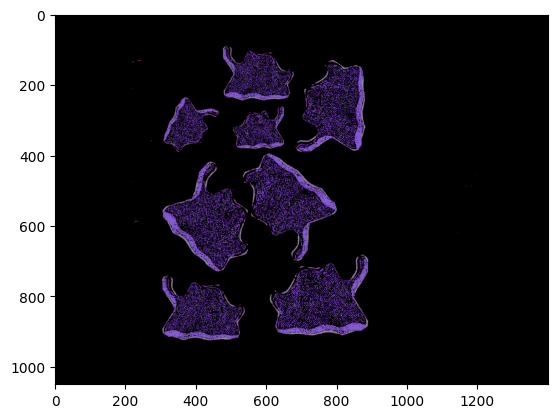

In [208]:
purple_mask = cv2.inRange(image, lower_purple, upper_purple)
purple_extracted = cv2.bitwise_and(image, image, mask=purple_mask)
display_image(purple_extracted)

For further processing, image must be converted to **binary** format, meaning that each pixel is either black or white.

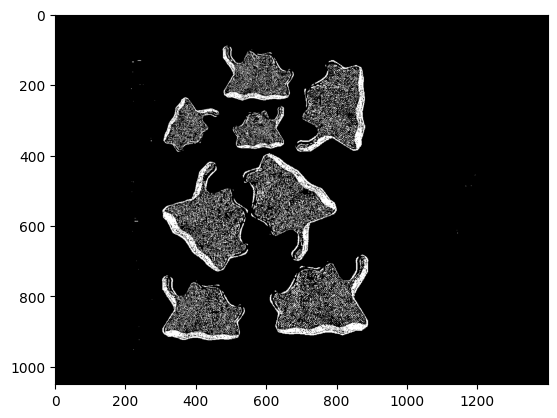

In [209]:
image = purple_extracted
ret, image_bin = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)
display_image(image_bin)

In image processing, a **kernel**, convolution matrix, or mask is a small matrix used for different image processing operations. This is accomplished by doing a convolution between the kernel and an image. Or more simply, kernel is a function where each pixel in the output image is a function of the nearby pixels (including itself) in the input image.

In [210]:
kernel = np.ones((3,3), np.uint8) # strukturni element 3x3 blok

In the code bellow, few morphological operations (using convolution) on image will be done.  

**Opening** removes small objects from the foreground (usually taken as the bright pixels) of an image, placing them in the background. Basically, it removes small disconnected objects.  
As can be seen bellow, opening does not work well with many shades of same color on the same object, so it won't be used in further processing.

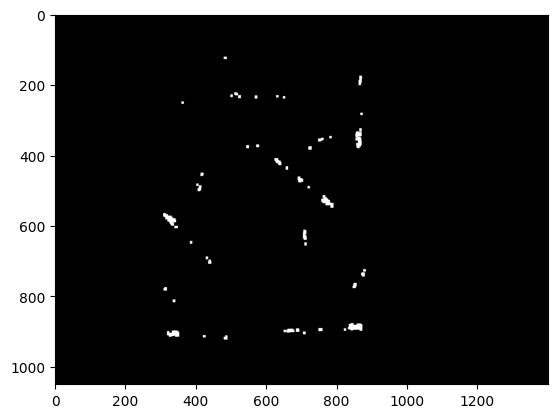

In [211]:
opening = cv2.morphologyEx(image_bin, cv2.MORPH_OPEN, kernel, iterations = 3) 
display_image(opening)

**Closing** is useful for filling small holes in an image while preserving the shape and size of large holes and objects in the image.  
This operation beautifully connected all different shades of purple that are contained in Ditto objects into the same mass, removing small holes.

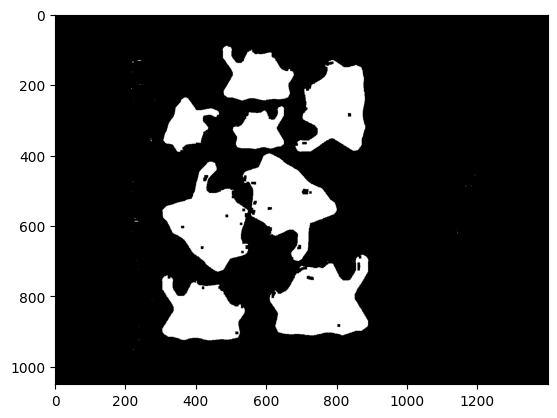

In [212]:
closing = cv2.morphologyEx(image_bin, cv2.MORPH_CLOSE, kernel, iterations = 3)
display_image(closing)

**Dilation** adds pixels to the boundaries of objects in an image. It usually uses a structuring element for probing and expanding the shapes contained in the input image.  
Now that dilation is applied, more details on image can be seen.

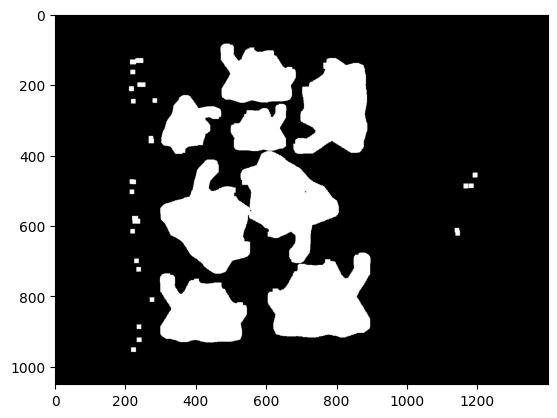

In [213]:
dilation = cv2.morphologyEx(image_bin, cv2.MORPH_DILATE, kernel, iterations = 6) 
display_image(dilation)

**Erosion** is a morphological operation that shrinks the boundaries of an object in an image.  
In this example, erosion recognized darker purple parts of image, which could be usefull for defining boundaries of objects, but won't be usefull in this example for further processing. 

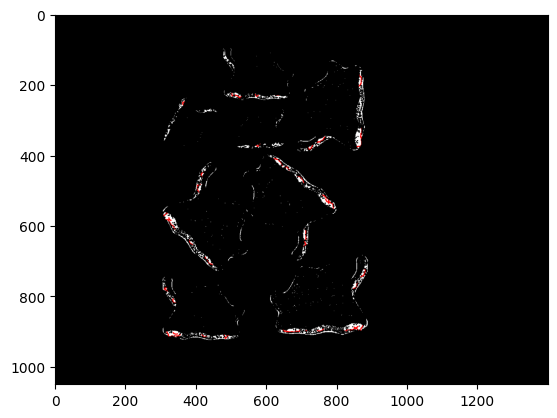

In [246]:
erosion = cv2.morphologyEx(image_bin, cv2.MORPH_ERODE, kernel, iterations = 1) 
display_image(erosion)

As dilation and closing gave the most details, they will be used in further processing.

Closing connected all the missing pieces of an object, meaning that almost everything not covered with closing should be in background.

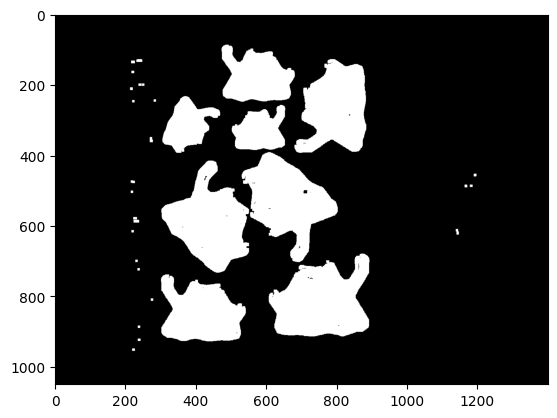

In [255]:
sure_bg = cv2.dilate(cv2.cvtColor(closing, cv2.COLOR_BGR2GRAY), kernel, iterations=3)
display_image(sure_bg)

**Distance transformation** is an image processing technique used to determine the distance of all background points to the nearest object point (or vice versa).

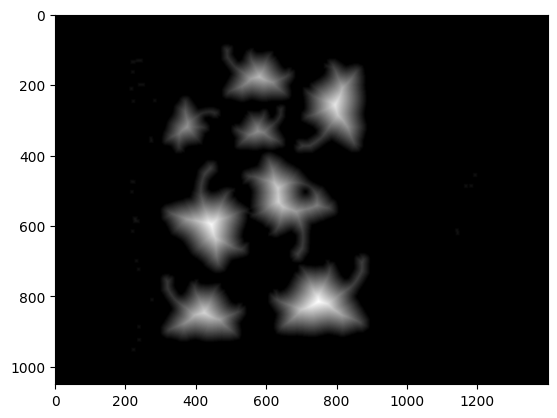

In [256]:
dist_transform = cv2.distanceTransform(cv2.cvtColor(dilation, cv2.COLOR_RGB2GRAY), cv2.DIST_L2, maskSize=5) 
display_image(dist_transform)

Because objects are connected, 50th percentile of distance transformation will be used to determine central parts of each object. 

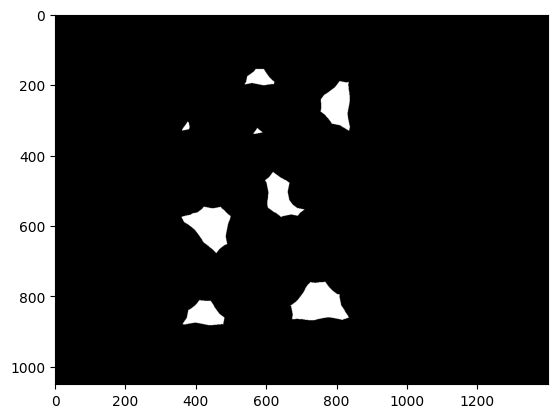

In [278]:
ret, sure_fg = cv2.threshold(dist_transform, 0.5 * dist_transform.max(), 255, 0) 
display_image(sure_fg)

By substracting parts of image that are for sure foreground (area around center of objects) from those that are for sure background, everything that still could be object or object's edge is saved.

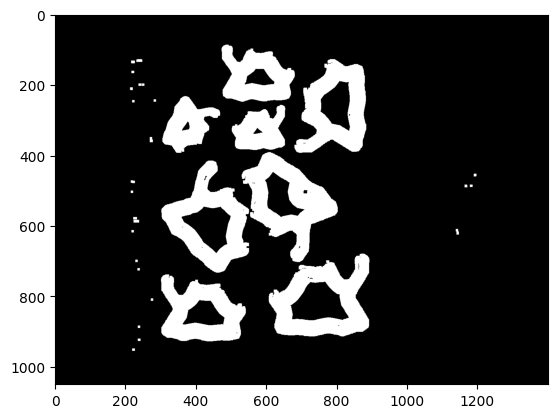

In [279]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
display_image(unknown)

Now that all objects are separated in foreground, they can be marked with different markers. Each marker can now get its corresponding color. This is the first step of **watershed algorithm**. What is left to do is to count number of unique colors on image.   

The watershed algorithm is especially useful for image segmentation when objects on image are touching or overlapping. Based on markers, the watershed algorithm treats pixels in input image as local elevation (called a topography) — the method “floods” valleys, starting from the markers and moving outwards, until the valleys of different markers meet each other. 

In [280]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0

On the image bellow, dark blue areas represent unknown parts of image.

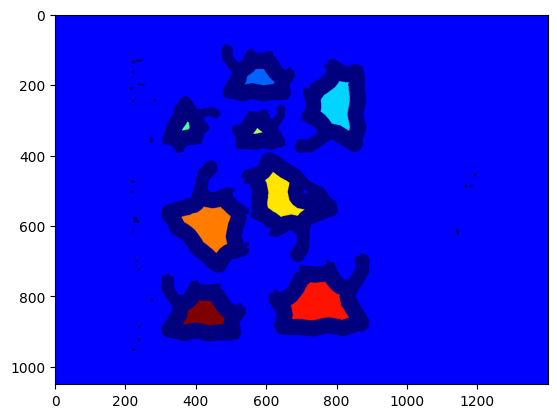

In [281]:
rgba_img = label2rgb(markers)
display_image(rgba_img, color=True)

Before counting number of markers (unique colors on image), final step of watershed algorithm is applied. That is, marking boundaries of object with -1, taking into consideration both foreground and unknow parts of image. 

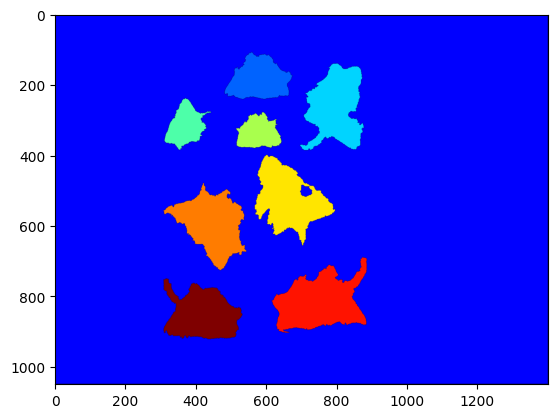

In [282]:
markers = cv2.watershed(image_bin, markers)
image_bin[markers == -1] = [255, 0, 0]
rgba_img = label2rgb(markers)
display_image(rgba_img, color=True)

What is left to do is to count unique colors on image. Number of objects corresponds to number of unique colors, substracted by 2 (one for background of image and one for edges of objects).

In [286]:
unique_colors = {x for l in markers for x in l}

In [287]:
number_of_dittos = len(unique_colors) - 2
print("Number of detected Dittos:", number_of_dittos)

Number of detected Dittos: 8
